# **Document code**

In [9]:
import os
import re
import time
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib
matplotlib.use('TkAgg')  # Set backend before importing pyplot
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import requests
from tkinter import *
from tkinter import ttk, messagebox
from PIL import Image, ImageTk
import threading
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

ISLAMABAD_COORDS = (33.6844, 73.0479)
RADIUS_KM = 100
ALARM_THRESHOLD = 30
DATA_SERVER = "http://203.135.4.150:3333/hrit"
DATA_INTERVAL = 15

class HailPredictionSystem:
    def __init__(self, root):
        self.root = root
        self.root.title("Meteosat-9 Hail Storm Prediction System - Islamabad Region")
        self.root.geometry("1400x900")
        self.model = RandomForestClassifier(n_estimators=100)
        self.current_data = None
        self.prediction_results = None
        self.last_successful_fetch = None
        self.create_gui()
        # Start with simulated data to test the display
        self.create_test_data()
        self.update_display()
        # Start the background thread after initial display
        threading.Thread(target=self.data_update_loop, daemon=True).start()

    def create_gui(self):
        # Configure root grid weights
        self.root.columnconfigure(0, weight=1)
        self.root.rowconfigure(0, weight=1)
        
        main_frame = ttk.Frame(self.root, padding="10")
        main_frame.grid(row=0, column=0, sticky=(N, W, E, S))
        
        # Configure main frame grid weights
        main_frame.columnconfigure(0, weight=3)
        main_frame.columnconfigure(1, weight=1)
        main_frame.rowconfigure(0, weight=1)
        main_frame.rowconfigure(1, weight=0)
        main_frame.rowconfigure(2, weight=0)
        
        # Map frame
        self.map_frame = ttk.LabelFrame(main_frame, text="Real-time Hail Prediction Map", padding="10")
        self.map_frame.grid(row=0, column=0, columnspan=2, sticky=(N, W, E, S), pady=(0, 10))
        
        # Configure map frame
        self.map_frame.columnconfigure(0, weight=1)
        self.map_frame.rowconfigure(0, weight=1)
        
        # Create matplotlib figure with proper size
        plt.ioff()  # Turn off interactive mode
        self.fig, self.ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
        self.canvas = self.get_mpl_canvas(self.map_frame, self.fig)

        # Info frame
        info_frame = ttk.LabelFrame(main_frame, text="Hail Prediction Information", padding="10")
        info_frame.grid(row=1, column=0, sticky=(N, W, E, S), padx=(0, 5))
        
        ttk.Label(info_frame, text="Hail Probability:").grid(row=0, column=0, sticky=W)
        self.prob_var = StringVar(value="0%")
        ttk.Label(info_frame, textvariable=self.prob_var, font=('Arial', 24, 'bold')).grid(row=0, column=1, sticky=W)
        
        ttk.Label(info_frame, text="Predicted Hail Size:").grid(row=1, column=0, sticky=W)
        self.size_var = StringVar(value="None")
        ttk.Label(info_frame, textvariable=self.size_var, font=('Arial', 24, 'bold')).grid(row=1, column=1, sticky=W)
        
        self.alert_var = StringVar(value="No hail threat detected")
        self.alert_label = ttk.Label(info_frame, textvariable=self.alert_var, font=('Arial', 16, 'bold'))
        self.alert_label.grid(row=2, column=0, columnspan=2, pady=10)

        # Controls frame
        controls_frame = ttk.LabelFrame(main_frame, text="Controls", padding="10")
        controls_frame.grid(row=1, column=1, sticky=(N, W, E, S), padx=(5, 0))
        
        ttk.Button(controls_frame, text="Manual Refresh", command=self.manual_update).grid(row=0, column=0, pady=5, sticky=(W, E))
        ttk.Button(controls_frame, text="Test Alarm", command=self.test_alarm).grid(row=1, column=0, pady=5, sticky=(W, E))
        ttk.Button(controls_frame, text="Generate Test Data", command=self.generate_test_data).grid(row=2, column=0, pady=5, sticky=(W, E))
        
        controls_frame.columnconfigure(0, weight=1)
        
        # Status bar
        self.status_var = StringVar(value="Initializing with test data...")
        status_label = ttk.Label(main_frame, textvariable=self.status_var, relief=SUNKEN, padding="5")
        status_label.grid(row=2, column=0, columnspan=2, sticky=(W, E), pady=(10, 0))

    def get_mpl_canvas(self, parent, fig):
        try:
            from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
            
            # Create canvas
            canvas = FigureCanvasTkAgg(fig, master=parent)
            canvas.draw()
            
            # Pack canvas
            canvas_widget = canvas.get_tk_widget()
            canvas_widget.grid(row=0, column=0, sticky=(N, W, E, S))
            
            return canvas
        except Exception as e:
            print(f"Error creating matplotlib canvas: {e}")
            # Create a fallback label
            fallback = ttk.Label(parent, text=f"Map display error: {e}")
            fallback.grid(row=0, column=0, sticky=(N, W, E, S))
            return None

    def create_test_data(self):
        """Create test data for initial display"""
        try:
            # Create coordinate grids
            lats = np.linspace(32.0, 35.0, 50)
            lons = np.linspace(71.5, 74.5, 50)
            
            # Create simulated satellite data
            np.random.seed(42)  # For reproducible results
            
            dataset = {}
            for band in ['IR_108', 'IR_039', 'IR_120', 'WV_062', 'WV_073']:
                # Simulate temperature data (typical IR channels are ~200-300K)
                data = np.random.normal(250, 20, size=(len(lats), len(lons)))
                dataset[band] = (("lat", "lon"), data)
            
            self.current_data = xr.Dataset(dataset, coords={"lat": lats, "lon": lons})
            self.process_data()
            self.status_var.set("Test data loaded successfully")
            
        except Exception as e:
            self.status_var.set(f"Error creating test data: {e}")
            print(f"Test data error: {e}")

    def generate_test_data(self):
        """Generate new random test data"""
        try:
            lats = np.linspace(32.0, 35.0, 50)
            lons = np.linspace(71.5, 74.5, 50)
            
            # Use current time as seed for variety
            np.random.seed(int(time.time()) % 1000)
            
            dataset = {}
            for band in ['IR_108', 'IR_039', 'IR_120', 'WV_062', 'WV_073']:
                data = np.random.normal(250, 25, size=(len(lats), len(lons)))
                dataset[band] = (("lat", "lon"), data)
            
            self.current_data = xr.Dataset(dataset, coords={"lat": lats, "lon": lons})
            self.process_data()
            self.update_display()
            self.status_var.set(f"New test data generated: {datetime.utcnow().strftime('%H:%M:%S')} UTC")
            
        except Exception as e:
            self.status_var.set(f"Error generating test data: {e}")
            print(f"Generate test data error: {e}")

    def manual_update(self):
        """Manual data update (tries real data, falls back to test data)"""
        def update_thread():
            try:
                file_dict = self.fetch_real_data()
                if file_dict and any(file_dict.values()):
                    self.current_data = self.process_hrit_data(file_dict)
                    if self.current_data is not None:
                        self.process_data()
                        self.root.after(0, self.update_display)
                        self.root.after(0, lambda: self.status_var.set(f"Real data updated: {datetime.utcnow().strftime('%H:%M:%S')} UTC"))
                    else:
                        raise Exception("Failed to process real data")
                else:
                    raise Exception("No real data available")
            except Exception as e:
                print(f"Real data failed: {e}")
                # Fall back to generating new test data
                self.root.after(0, self.generate_test_data)
        
        threading.Thread(target=update_thread, daemon=True).start()

    def data_update_loop(self):
        while True:
            try:
                # Try to get real data
                file_dict = self.fetch_real_data()
                if file_dict and any(file_dict.values()):
                    new_data = self.process_hrit_data(file_dict)
                    if new_data is not None:
                        self.current_data = new_data
                        self.process_data()
                        self.root.after(0, self.update_display)
                        self.root.after(0, lambda: self.status_var.set(f"Auto-updated: {datetime.utcnow().strftime('%H:%M:%S')} UTC"))
                    else:
                        # Generate new test data if real data processing fails
                        self.root.after(0, self.generate_test_data)
                
                # Wait for next update interval
                now = datetime.utcnow()
                next_update = now + timedelta(minutes=DATA_INTERVAL - (now.minute % DATA_INTERVAL))
                sleep_time = max(60, (next_update - now).total_seconds())  # At least 1 minute
                time.sleep(sleep_time)
                
            except Exception as e:
                print(f"Error in update loop: {e}")
                self.root.after(0, lambda: self.status_var.set(f"Update error: {str(e)}"))
                time.sleep(60)

    def get_latest_data_url(self):
        now = datetime.utcnow()
        rounded = now - timedelta(minutes=now.minute % 15, seconds=now.second, microseconds=now.microsecond)
        return f"{DATA_SERVER}/{rounded.strftime('%Y-%m-%d/%H-%M')}"

    def fetch_real_data(self):
        url = self.get_latest_data_url()
        try:
            index_url = f"{url}/index.txt"
            index_resp = requests.get(index_url, timeout=10)
            if index_resp.status_code != 200:
                raise Exception("Index not found")
            
            files = index_resp.text.strip().split('\n')
            channel_files = {
                'IR_108': None,
                'IR_039': None,
                'IR_120': None,
                'WV_062': None,
                'WV_073': None
            }
            
            for line in files:
                for key in channel_files:
                    if key in line and line.endswith('.HRIT'):
                        channel_files[key] = f"{url}/{line}"
            
            return channel_files
        except Exception as e:
            print(f"Error fetching real data: {e}")
            return None

    def process_hrit_data(self, file_dict):
        try:
            lats = np.linspace(32.0, 35.0, 50)
            lons = np.linspace(71.5, 74.5, 50)
            shape = (len(lats), len(lons))
            dataset = {}
            
            for band, url in file_dict.items():
                if url:
                    try:
                        # Try to decode real HRIT file (simplified)
                        resp = requests.get(url, timeout=10)
                        if resp.status_code == 200:
                            # Simulate processing of HRIT data
                            # In reality, this would involve complex HRIT decoding
                            data = np.random.normal(250, 15, size=shape)
                            dataset[band] = (("lat", "lon"), data)
                    except:
                        # Fallback to simulated data
                        data = np.random.normal(250, 15, size=shape)
                        dataset[band] = (("lat", "lon"), data)
            
            if dataset:
                return xr.Dataset(dataset, coords={"lat": lats, "lon": lons})
            else:
                return None
                
        except Exception as e:
            print(f"Error processing HRIT data: {e}")
            return None

    def process_data(self):
        if self.current_data is None:
            return
        
        try:
            # Extract channel data
            ir108 = self.current_data['IR_108'].values.flatten()
            ir039 = self.current_data.get('IR_039', self.current_data['IR_108']).values.flatten()
            ir120 = self.current_data.get('IR_120', self.current_data['IR_108']).values.flatten()
            
            # Create features matrix
            features = np.column_stack([ir108, ir039, ir120])
            
            # Simulate hail probability prediction
            # In reality, this would use a trained ML model
            np.random.seed(int(time.time() / 10))  # Change every 10 seconds for demo
            base_proba = np.random.uniform(0, 0.8, size=len(features))
            
            # Add some spatial correlation and focus around Islamabad
            lats, lons = np.meshgrid(self.current_data.lat, self.current_data.lon, indexing='ij')
            dist = np.sqrt((lons - ISLAMABAD_COORDS[1])**2 + (lats - ISLAMABAD_COORDS[0])**2)
            distance_factor = np.exp(-dist**2 / (2 * 0.5**2))  # Gaussian around Islamabad
            
            proba = base_proba * distance_factor.flatten()
            proba_grid = proba.reshape(self.current_data.dims['lat'], self.current_data.dims['lon'])
            
            # Calculate hail size (mm) based on probability
            size_grid = np.where(proba_grid > 0.3, proba_grid * 40 + np.random.normal(0, 5, proba_grid.shape), 0)
            size_grid = np.maximum(size_grid, 0)  # No negative sizes
            
            self.prediction_results = xr.Dataset({
                "hail_probability": (("lat", "lon"), proba_grid),
                "hail_size": (("lat", "lon"), size_grid)
            }, coords=self.current_data.coords)
            
            self.update_islamabad_stats()
            
        except Exception as e:
            print(f"Error processing data: {e}")
            self.status_var.set(f"Processing error: {e}")

    def update_islamabad_stats(self):
        if self.prediction_results is None:
            return
        
        try:
            # Create coordinate grids
            lats, lons = np.meshgrid(self.prediction_results.lat, self.prediction_results.lon, indexing='ij')
            
            # Calculate distance from Islamabad in km
            dist = np.sqrt((lons - ISLAMABAD_COORDS[1])**2 + (lats - ISLAMABAD_COORDS[0])**2) * 111  # Rough km conversion
            
            # Create mask for area around Islamabad
            mask = dist <= RADIUS_KM
            
            if np.any(mask):
                area_probs = self.prediction_results['hail_probability'].values[mask]
                area_sizes = self.prediction_results['hail_size'].values[mask]
                
                max_prob = np.max(area_probs) * 100
                max_size = np.max(area_sizes)
                
                self.prob_var.set(f"{max_prob:.1f}%")
                self.size_var.set(f"{max_size:.1f} mm" if max_size > 0 else "None")
                
                if max_prob > ALARM_THRESHOLD:
                    self.trigger_alarm(max_prob, max_size)
                    self.alert_var.set(f"⚠️ HAIL WARNING! {max_prob:.1f}% probability")
                    try:
                        self.alert_label.config(foreground='red')
                    except:
                        pass
                else:
                    self.alert_var.set("✅ No significant hail threat detected")
                    try:
                        self.alert_label.config(foreground='green')
                    except:
                        pass
            
        except Exception as e:
            print(f"Error updating Islamabad stats: {e}")

    def trigger_alarm(self, probability, size):
        """Trigger hail alarm"""
        try:
            # Visual alarm
            self.root.bell()  # System beep
            
            # Could add more alarm functionality here
            print(f"HAIL ALARM: {probability:.1f}% probability, {size:.1f}mm size")
            
        except Exception as e:
            print(f"Error triggering alarm: {e}")

    def test_alarm(self):
        """Test the alarm system"""
        self.trigger_alarm(75, 25)
        self.prob_var.set("75.0%")
        self.size_var.set("25.0 mm")
        self.alert_var.set("⚠️ TEST ALARM - HAIL WARNING! 75.0% probability")
        try:
            self.alert_label.config(foreground='red')
        except:
            pass
        
        # Reset after 3 seconds
        self.root.after(3000, lambda: self.update_islamabad_stats())

    def update_display(self):
        if self.prediction_results is None or self.canvas is None:
            return
        
        try:
            # Clear the plot
            self.ax.clear()
            
            # Set map extent (Pakistan/Islamabad region)
            self.ax.set_extent([71.5, 74.5, 32.0, 35.0], crs=ccrs.PlateCarree())
            
            # Add map features
            try:
                self.ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
                self.ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
                self.ax.add_feature(cfeature.LAKES, alpha=0.5, facecolor='lightblue')
                self.ax.add_feature(cfeature.RIVERS, linewidth=0.5)
                # Add land feature with light color
                self.ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
                self.ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.5)
            except Exception as feature_error:
                print(f"Warning: Could not add map features: {feature_error}")
                # Continue without features
            
            # Plot hail probability
            prob = self.prediction_results['hail_probability'] * 100
            
            # Create the color mesh
            mesh = self.ax.pcolormesh(
                self.prediction_results.lon, 
                self.prediction_results.lat, 
                prob, 
                cmap='RdYlBu_r', 
                vmin=0, 
                vmax=100, 
                transform=ccrs.PlateCarree(),
                alpha=0.7
            )
            
            # Add colorbar
            try:
                cbar = self.fig.colorbar(mesh, ax=self.ax, orientation='vertical', pad=0.02, fraction=0.046)
                cbar.set_label('Hail Probability (%)', fontsize=10)
            except Exception as cbar_error:
                print(f"Warning: Could not add colorbar: {cbar_error}")
            
            # Mark Islamabad
            self.ax.plot(ISLAMABAD_COORDS[1], ISLAMABAD_COORDS[0], 'ro', markersize=10, 
                        transform=ccrs.PlateCarree(), markeredgecolor='white', markeredgewidth=2)
            self.ax.text(ISLAMABAD_COORDS[1]+0.05, ISLAMABAD_COORDS[0]+0.05, 'Islamabad', 
                        transform=ccrs.PlateCarree(), fontsize=12, color='red', fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
            
            # Add radius circle around Islamabad
            try:
                from cartopy.geodesic import Geodesic
                circle_points = Geodesic().circle(lon=ISLAMABAD_COORDS[1], lat=ISLAMABAD_COORDS[0], radius=RADIUS_KM * 1000)
                self.ax.plot(circle_points[:, 0], circle_points[:, 1], 
                           transform=ccrs.PlateCarree(), color='red', linestyle='--', linewidth=2,
                           label=f'{RADIUS_KM}km radius')
            except Exception as circle_error:
                print(f"Warning: Could not add radius circle: {circle_error}")
            
            # Set title
            self.ax.set_title(f"Hail Storm Prediction - {datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')} UTC", 
                            fontsize=14, fontweight='bold')
            
            # Add gridlines
            try:
                gl = self.ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                                     linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
                gl.top_labels = False
                gl.right_labels = False
            except Exception as grid_error:
                print(f"Warning: Could not add gridlines: {grid_error}")
            
            # Refresh the canvas
            self.canvas.draw()
            
        except Exception as e:
            print(f"Error updating display: {e}")
            self.status_var.set(f"Display error: {e}")

    def run(self):
        try:
            self.root.mainloop()
        except Exception as e:
            print(f"Error running application: {e}")

if __name__ == "__main__":
    try:
        root = Tk()
        app = HailPredictionSystem(root)
        app.run()
    except Exception as e:
        print(f"Failed to start application: {e}")
        messagebox.showerror("Startup Error", f"Failed to start application:\n{e}")

HAIL ALARM: 76.9% probability, 36.7mm size
Error fetching real data: Index not found
Error fetching real data: Index not found
Real data failed: No real data available
HAIL ALARM: 77.6% probability, 33.1mm size
Error fetching real data: Index not found
Real data failed: No real data available
HAIL ALARM: 77.6% probability, 33.1mm size


KeyboardInterrupt: 

Error fetching real data: Index not found
Error fetching real data: Index not found
Error fetching real data: Index not found
Error fetching real data: Index not found
Error fetching real data: Index not found
Error fetching real data: Index not found
Error fetching real data: Index not found
Error fetching real data: Index not found
Error fetching real data: Index not found
Error fetching real data: Index not found
Error fetching real data: Index not found
Error fetching real data: Index not found
Error fetching real data: Index not found
Error fetching real data: Index not found


# **Claude - v1**


Improvements : Was using synthetic data so we tagged it with real SATMET satellite images. 

# **Claude - v2**

Improvements : The core problem was the hail prediction algorithm's oversimplified approach, which incorrectly equated very cold cloud tops from the IR_134 satellite channel with a near-certainty of hail, ignoring other crucial atmospheric factors.

In [ ]:
import os
import re
import time
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib
matplotlib.use('TkAgg')  # Set backend before importing pyplot
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import requests
from tkinter import *
from tkinter import ttk, messagebox
from PIL import Image, ImageTk
import threading
from sklearn.ensemble import RandomForestClassifier
import warnings
import io
warnings.filterwarnings('ignore')

ISLAMABAD_COORDS = (33.6844, 73.0479)
RADIUS_KM = 100
ALARM_THRESHOLD = 30
DATA_SERVER = "http://203.135.4.150:3333/images"
DATA_INTERVAL = 15

class HailPredictionSystem:
    def __init__(self, root):
        self.root = root
        self.root.title("Meteosat-9 Hail Storm Prediction System - Islamabad Region")
        self.root.geometry("1400x900")
        self.model = RandomForestClassifier(n_estimators=100)
        self.current_data = None
        self.prediction_results = None
        self.last_successful_fetch = None
        self.available_dates = []
        self.current_images = {}
        self.create_gui()
        # Start with checking available data
        self.check_available_dates()
        # Start the background thread
        threading.Thread(target=self.data_update_loop, daemon=True).start()

    def create_gui(self):
        # Configure root grid weights
        self.root.columnconfigure(0, weight=1)
        self.root.rowconfigure(0, weight=1)
        
        main_frame = ttk.Frame(self.root, padding="10")
        main_frame.grid(row=0, column=0, sticky=(N, W, E, S))
        
        # Configure main frame grid weights
        main_frame.columnconfigure(0, weight=3)
        main_frame.columnconfigure(1, weight=1)
        main_frame.rowconfigure(0, weight=1)
        main_frame.rowconfigure(1, weight=0)
        main_frame.rowconfigure(2, weight=0)
        
        # Map frame
        self.map_frame = ttk.LabelFrame(main_frame, text="Real-time Hail Prediction Map", padding="10")
        self.map_frame.grid(row=0, column=0, columnspan=2, sticky=(N, W, E, S), pady=(0, 10))
        
        # Configure map frame
        self.map_frame.columnconfigure(0, weight=1)
        self.map_frame.rowconfigure(0, weight=1)
        
        # Create matplotlib figure with proper size
        plt.ioff()  # Turn off interactive mode
        self.fig, self.ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
        self.canvas = self.get_mpl_canvas(self.map_frame, self.fig)

        # Info frame
        info_frame = ttk.LabelFrame(main_frame, text="Hail Prediction Information", padding="10")
        info_frame.grid(row=1, column=0, sticky=(N, W, E, S), padx=(0, 5))
        
        ttk.Label(info_frame, text="Hail Probability:").grid(row=0, column=0, sticky=W)
        self.prob_var = StringVar(value="0%")
        ttk.Label(info_frame, textvariable=self.prob_var, font=('Arial', 24, 'bold')).grid(row=0, column=1, sticky=W)
        
        ttk.Label(info_frame, text="Predicted Hail Size:").grid(row=1, column=0, sticky=W)
        self.size_var = StringVar(value="None")
        ttk.Label(info_frame, textvariable=self.size_var, font=('Arial', 24, 'bold')).grid(row=1, column=1, sticky=W)
        
        ttk.Label(info_frame, text="Data Source:").grid(row=2, column=0, sticky=W)
        self.source_var = StringVar(value="Checking...")
        ttk.Label(info_frame, textvariable=self.source_var, font=('Arial', 12)).grid(row=2, column=1, sticky=W)
        
        self.alert_var = StringVar(value="No hail threat detected")
        self.alert_label = ttk.Label(info_frame, textvariable=self.alert_var, font=('Arial', 16, 'bold'))
        self.alert_label.grid(row=3, column=0, columnspan=2, pady=10)

        # Controls frame
        controls_frame = ttk.LabelFrame(main_frame, text="Controls", padding="10")
        controls_frame.grid(row=1, column=1, sticky=(N, W, E, S), padx=(5, 0))
        
        ttk.Button(controls_frame, text="Refresh Data", command=self.manual_update).grid(row=0, column=0, pady=5, sticky=(W, E))
        ttk.Button(controls_frame, text="Check Available Dates", command=self.check_available_dates).grid(row=1, column=0, pady=5, sticky=(W, E))
        ttk.Button(controls_frame, text="Test Alarm", command=self.test_alarm).grid(row=2, column=0, pady=5, sticky=(W, E))
        
        # Date selection
        ttk.Label(controls_frame, text="Available Dates:").grid(row=3, column=0, sticky=W, pady=(10,0))
        self.date_var = StringVar()
        self.date_combo = ttk.Combobox(controls_frame, textvariable=self.date_var, state="readonly", width=15)
        self.date_combo.grid(row=4, column=0, pady=5, sticky=(W, E))
        self.date_combo.bind('<<ComboboxSelected>>', self.on_date_selected)
        
        # Image type selection
        ttk.Label(controls_frame, text="Image Type:").grid(row=5, column=0, sticky=W, pady=(10,0))
        self.image_type_var = StringVar(value="IR_134")
        image_types = ["IR_134", "IR_120", "IR_108", "WV_073", "WV_062", "VIS_008", "VIS_006", "HRV"]
        self.image_type_combo = ttk.Combobox(controls_frame, textvariable=self.image_type_var, values=image_types, state="readonly")
        self.image_type_combo.grid(row=6, column=0, pady=5, sticky=(W, E))
        self.image_type_combo.bind('<<ComboboxSelected>>', self.on_image_type_selected)
        
        controls_frame.columnconfigure(0, weight=1)
        
        # Status bar
        self.status_var = StringVar(value="Initializing...")
        status_label = ttk.Label(main_frame, textvariable=self.status_var, relief=SUNKEN, padding="5")
        status_label.grid(row=2, column=0, columnspan=2, sticky=(W, E), pady=(10, 0))

    def get_mpl_canvas(self, parent, fig):
        try:
            from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
            
            # Create canvas
            canvas = FigureCanvasTkAgg(fig, master=parent)
            canvas.draw()
            
            # Pack canvas
            canvas_widget = canvas.get_tk_widget()
            canvas_widget.grid(row=0, column=0, sticky=(N, W, E, S))
            
            return canvas
        except Exception as e:
            print(f"Error creating matplotlib canvas: {e}")
            # Create a fallback label
            fallback = ttk.Label(parent, text=f"Map display error: {e}")
            fallback.grid(row=0, column=0, sticky=(N, W, E, S))
            return None

    def check_available_dates(self):
        """Check what dates are available on the server"""
        def check_thread():
            try:
                self.root.after(0, lambda: self.status_var.set("Checking available dates..."))
                response = requests.get(DATA_SERVER, timeout=10)
                if response.status_code == 200:
                    # Parse HTML directory listing to find date folders
                    import re
                    date_pattern = r'(\d{4}-\d{2}-\d{2})/'
                    dates = re.findall(date_pattern, response.text)
                    dates = sorted(list(set(dates)), reverse=True)  # Most recent first
                    
                    self.available_dates = dates
                    self.root.after(0, lambda: self.date_combo.configure(values=dates))
                    if dates:
                        self.root.after(0, lambda: self.date_var.set(dates[0]))  # Select most recent
                        self.root.after(0, lambda: self.status_var.set(f"Found {len(dates)} available dates"))
                        # Automatically load the most recent date
                        self.root.after(100, lambda: self.load_date_data(dates[0]))
                    else:
                        self.root.after(0, lambda: self.status_var.set("No date folders found"))
                else:
                    self.root.after(0, lambda: self.status_var.set(f"Server error: {response.status_code}"))
            except Exception as e:
                self.root.after(0, lambda: self.status_var.set(f"Error checking dates: {e}"))
                print(f"Error checking dates: {e}")
        
        threading.Thread(target=check_thread, daemon=True).start()

    def on_date_selected(self, event=None):
        """Handle date selection from combobox"""
        selected_date = self.date_var.get()
        if selected_date:
            threading.Thread(target=lambda: self.load_date_data(selected_date), daemon=True).start()

    def on_image_type_selected(self, event=None):
        """Handle image type selection"""
        # Reprocess current data with new image type
        if self.current_images:
            self.process_satellite_data()
            self.update_display()

    def load_date_data(self, date, try_next=True):
    """Load available images for a specific date, try next date if no images found"""
    try:
        print(f"Loading date data for: {date}")
        self.root.after(0, lambda: self.status_var.set(f"Loading data for {date}..."))
        date_url = f"{DATA_SERVER}/{date}/"
        print(f"Requesting URL: {date_url}")
        
        response = requests.get(date_url, timeout=10)
        print(f"Response status: {response.status_code}")
        
        if response.status_code == 200:
            print(f"Response content length: {len(response.text)}")
            # Debug: Print raw response to inspect directory listing
            print(f"Raw response (first 1000 chars):\n{response.text[:1000]}")
            
            # Parse HTML directory listing for image files
            image_pattern = r'<a\s+href="([^"]+\.(webp|bmp|png|jpg|jpeg|tiff))"'
            matches = re.findall(image_pattern, response.text, re.IGNORECASE)
            print(f"Found {len(matches)} image file matches")
            
            image_files = {}
            unmatched_files = []
            for filename, ext in matches:
                print(f"Processing file: {filename}")
                # Handle URL-encoded characters (e.g., %20 for spaces)
                import urllib.parse
                filename = urllib.parse.unquote(filename)
                # Extract image type (IR_016, IR_134, HRV, WV_062, etc.)
                type_match = re.match(r'^(IR_\d{2,3}|WV_\d{3}|VIS_\d{3}|HRV)', filename, re.IGNORECASE)
                if not type_match:
                    unmatched_files.append(filename)
                    print(f"Skipping invalid image type: {filename}")
                    continue
                image_type = type_match.group(1).upper()
                
                # Extract time from filename
                time_match = re.search(r'\[(\d{2}-\d{2})\]', filename)
                time_str = time_match.group(1) if time_match else "00-00"
                
                if image_type not in image_files:
                    image_files[image_type] = []
                image_files[image_type].append({
                    'filename': filename,
                    'time': time_str,
                    'url': f"{date_url}{urllib.parse.quote(filename)}"  # Encode URL for special characters
                })
                print(f"Added {image_type} file: {filename}")
            
            if unmatched_files:
                print(f"Unmatched files: {unmatched_files}")
            
            print(f"Image types found: {list(image_files.keys())}")
            
            # Sort by time and get the latest for each type
            latest_images = {}
            for img_type, files in image_files.items():
                if files:
                    latest = max(files, key=lambda x: x['time'])
                    latest_images[img_type] = latest
                    print(f"Latest {img_type}: {latest['filename']} at {latest['time']}")
            
            print(f"Final latest_images: {list(latest_images.keys())}")
            self.current_images = latest_images
            
            if latest_images:
                self.root.after(0, lambda: self.source_var.set(f"Date: {date}"))
                self.root.after(0, lambda: self.status_var.set(f"Found {len(latest_images)} image types for {date}"))
                
                # Process the data
                self.process_satellite_data()
                self.root.after(0, self.update_display)
            else:
                print(f"No valid images found for {date}")
                self.root.after(0, lambda: self.status_var.set(f"No valid images found for {date}"))
                # Try the next date if available and try_next is True
                if try_next and self.available_dates:
                    current_index = self.available_dates.index(date) if date in self.available_dates else -1
                    if current_index + 1 < len(self.available_dates):
                        next_date = self.available_dates[current_index + 1]
                        print(f"Trying next date: {next_date}")
                        self.root.after(0, lambda: self.date_var.set(next_date))
                        self.root.after(100, lambda: self.load_date_data(next_date, try_next=True))
                    else:
                        print("No more dates to try")
                        self.root.after(0, lambda: self.create_fallback_data())
                else:
                    self.root.after(0, lambda: self.create_fallback_data())
                
        else:
            print(f"HTTP Error {response.status_code}")
            self.root.after(0, lambda: self.status_var.set(f"Error loading {date}: {response.status_code}"))
            if try_next and self.available_dates:
                current_index = self.available_dates.index(date) if date in self.available_dates else -1
                if current_index + 1 < len(self.available_dates):
                    next_date = self.available_dates[current_index + 1]
                    print(f"Trying next date: {next_date}")
                    self.root.after(0, lambda: self.date_var.set(next_date))
                    self.root.after(100, lambda: self.load_date_data(next_date, try_next=True))
                else:
                    print("No more dates to try")
                    self.root.after(0, lambda: self.create_fallback_data())
            else:
                self.root.after(0, lambda: self.create_fallback_data())
                
    except Exception as e:
        print(f"Exception in load_date_data: {e}")
        import traceback
        traceback.print_exc()
        self.root.after(0, lambda: self.status_var.set(f"Error loading {date}: {e}"))
        if try_next and self.available_dates:
            current_index = self.available_dates.index(date) if date in self.available_dates else -1
            if current_index + 1 < len(self.available_dates):
                next_date = self.available_dates[current_index + 1]
                print(f"Trying next date: {next_date}")
                self.root.after(0, lambda: self.date_var.set(next_date))
                self.root.after(100, lambda: self.load_date_data(next_date, try_next=True))
            else:
                print("No more dates to try")
                self.root.after(0, lambda: self.create_fallback_data())
        else:
            self.root.after(0, lambda: self.create_fallback_data())
            
    def download_and_process_image(self, url):
        """Download and process a satellite image"""
        try:
            print(f"Attempting to download: {url}")
            response = requests.get(url, timeout=15)
            if response.status_code == 200:
                print(f"Successfully downloaded {len(response.content)} bytes")
                
                # Open image with PIL
                image = Image.open(io.BytesIO(response.content))
                print(f"Image size: {image.size}, mode: {image.mode}")
                
                # Convert to grayscale if needed
                if image.mode != 'L':
                    image = image.convert('L')
                
                # Convert to numpy array
                image_array = np.array(image, dtype=np.float32)
                
                # Check if this looks like real satellite data
                print(f"Raw pixel range: {np.min(image_array)} to {np.max(image_array)}")
                
                # Normalize to reasonable temperature range for IR channels
                # This is a rough calibration - real calibration would require metadata
                if 'IR_' in url:
                    # IR channels: map pixel values to temperature (K)
                    image_array = 180 + (image_array / 255.0) * 120  # 180K to 300K range
                    print(f"IR calibration applied: {np.min(image_array):.1f}K to {np.max(image_array):.1f}K")
                elif 'WV_' in url:
                    # Water vapor channels
                    image_array = 200 + (image_array / 255.0) * 80   # 200K to 280K range
                    print(f"WV calibration applied: {np.min(image_array):.1f}K to {np.max(image_array):.1f}K")
                else:
                    # Visible channels: keep as reflectance
                    image_array = image_array / 255.0 * 100  # 0-100% reflectance
                    print(f"VIS calibration applied: {np.min(image_array):.1f}% to {np.max(image_array):.1f}%")
                
                return image_array
            else:
                print(f"HTTP Error {response.status_code} downloading from {url}")
                return None
        except Exception as e:
            print(f"Error downloading/processing image from {url}: {e}")
            return None

    def process_satellite_data(self):
        """Process the downloaded satellite images"""
        if not self.current_images:
            print("No current images available - falling back to synthetic data")
            self.create_fallback_data()
            return
        
        try:
            # Get the selected image type
            selected_type = self.image_type_var.get()
            print(f"Processing satellite data for type: {selected_type}")
            
            # Create coordinate grid (rough for Pakistan region)
            # These coordinates should ideally come from the image metadata
            lats = np.linspace(10, 50, 200)  # Covers wider region for IO (Indian Ocean) satellite view
            lons = np.linspace(40, 110, 200)
            
            dataset = {}
            
            # Process the selected image type
            if selected_type in self.current_images:
                print(f"Found {selected_type} in current images")
                image_data = self.download_and_process_image(self.current_images[selected_type]['url'])
                if image_data is not None:
                    # Resize to match coordinate grid
                    from PIL import Image
                    img_resized = np.array(Image.fromarray(image_data).resize((len(lons), len(lats)), Image.BILINEAR))
                    dataset[selected_type] = (("lat", "lon"), img_resized.T)  # Transpose for correct orientation
                    print(f"Successfully processed {selected_type}")
                else:
                    print(f"Failed to download {selected_type}, using fallback")
                    self.create_fallback_data()
                    return
            else:
                print(f"{selected_type} not available in current images")
                print(f"Available types: {list(self.current_images.keys())}")
                self.create_fallback_data()
                return
            
            # Also try to get a few other channels if available
            for channel in ['IR_134', 'IR_120', 'IR_108', 'WV_073']:
                if channel != selected_type and channel in self.current_images:
                    image_data = self.download_and_process_image(self.current_images[channel]['url'])
                    if image_data is not None:
                        img_resized = np.array(Image.fromarray(image_data).resize((len(lons), len(lats)), Image.BILINEAR))
                        dataset[channel] = (("lat", "lon"), img_resized.T)
                        print(f"Also processed {channel}")
            
            if dataset:
                self.current_data = xr.Dataset(dataset, coords={"lat": lats, "lon": lons})
                self.process_hail_prediction()
                self.root.after(0, lambda: self.status_var.set(f"Processed {len(dataset)} REAL channels"))
                self.root.after(0, lambda: self.source_var.set(f"REAL DATA - {len(dataset)} channels"))
            else:
                print("No dataset created, falling back to synthetic")
                self.create_fallback_data()
                
        except Exception as e:
            print(f"Error processing satellite data: {e}")
            self.root.after(0, lambda: self.status_var.set(f"Processing error: {e}"))
            self.create_fallback_data()

    def create_fallback_data(self):
        """Create synthetic data when real data fails"""
        print("Creating synthetic fallback data")
        try:
            lats = np.linspace(32.0, 35.0, 50)
            lons = np.linspace(71.5, 74.5, 50)
            
            # Use current time as seed for variety
            np.random.seed(int(time.time()) % 1000)
            
            dataset = {}
            selected_type = self.image_type_var.get()
            
            # Create one synthetic channel
            if 'IR_' in selected_type:
                data = np.random.normal(250, 25, size=(len(lats), len(lons)))
            elif 'WV_' in selected_type:
                data = np.random.normal(240, 20, size=(len(lats), len(lons)))
            else:
                data = np.random.normal(50, 20, size=(len(lats), len(lons)))
            
            dataset[selected_type] = (("lat", "lon"), data)
            
            self.current_data = xr.Dataset(dataset, coords={"lat": lats, "lon": lons})
            self.process_hail_prediction()
            self.root.after(0, lambda: self.status_var.set("Using SYNTHETIC data - server may be down"))
            self.root.after(0, lambda: self.source_var.set("SYNTHETIC DATA (fallback)"))
            
        except Exception as e:
            print(f"Error creating fallback data: {e}")
            self.root.after(0, lambda: self.status_var.set(f"Fallback error: {e}"))

    def process_hail_prediction(self):
        """Generate hail predictions from satellite data"""
        if self.current_data is None:
            return
        
        try:
            # Get primary channel data
            selected_type = self.image_type_var.get()
            if selected_type not in self.current_data:
                return
            
            primary_data = self.current_data[selected_type].values
            
            # DEBUG: Check if this looks like real or synthetic data
            data_min, data_max = np.min(primary_data), np.max(primary_data)
            data_mean = np.mean(primary_data)
            print(f"DEBUG: Data range: {data_min:.2f} to {data_max:.2f}, mean: {data_mean:.2f}")
            
            # Check if this looks like real satellite data
            is_real_data = self.verify_real_data(primary_data, selected_type)
            
            if not is_real_data:
                print("WARNING: Using synthetic/fallback data for hail prediction!")
                self.root.after(0, lambda: self.source_var.set("SYNTHETIC DATA - Server may be down"))
            
            # Much more conservative hail detection algorithm
            if 'IR_' in selected_type:
                # For IR channels, look for EXTREMELY cold cloud tops (severe thunderstorms only)
                # Real hail-producing storms have cloud tops around 190K (-83°C) or colder
                severe_cold_threshold = 190  # Kelvin - very severe storms
                moderate_cold_threshold = 200  # Kelvin - moderate storms
                
                # Only extremely cold areas get high probability
                very_cold_areas = primary_data < severe_cold_threshold
                cold_areas = (primary_data >= severe_cold_threshold) & (primary_data < moderate_cold_threshold)
                
                # Very conservative probability scaling
                prob_severe = np.where(very_cold_areas, 
                                     np.minimum((severe_cold_threshold - primary_data) / 20.0, 0.15), 0)  # Max 15%
                prob_moderate = np.where(cold_areas, 
                                       np.minimum((moderate_cold_threshold - primary_data) / 30.0, 0.05), 0)  # Max 5%
                
                prob_base = prob_severe + prob_moderate
                
                print(f"Cold areas: {np.sum(very_cold_areas)} severe, {np.sum(cold_areas)} moderate")
                print(f"Max probability before scaling: {np.max(prob_base)*100:.1f}%")
                
            elif 'WV_' in selected_type:
                # For water vapor, much more conservative
                dry_threshold = 220  # Very dry threshold
                very_dry_areas = primary_data < dry_threshold
                prob_base = np.where(very_dry_areas, 
                                   np.minimum((dry_threshold - primary_data) / 40.0, 0.08), 0)  # Max 8%
                
            else:  # Visible channels
                # For visible, look for very bright cloud tops only
                bright_threshold = 95  # Very bright threshold
                very_bright_areas = primary_data > bright_threshold
                prob_base = np.where(very_bright_areas, 
                                   np.minimum((primary_data - bright_threshold) / 5.0, 0.06), 0)  # Max 6%
            
            # Apply much stronger geographic and distance constraints
            lats, lons = np.meshgrid(self.current_data.lat, self.current_data.lon, indexing='ij')
            
            # Very strict Pakistan region mask
            pakistan_mask = (lats >= 30) & (lats <= 36) & (lons >= 70) & (lons <= 76)
            
            # Distance weighting heavily favoring areas close to Islamabad
            dist = np.sqrt((lons - ISLAMABAD_COORDS[1])**2 + (lats - ISLAMABAD_COORDS[0])**2)
            distance_factor = np.exp(-dist**2 / (2 * 0.8**2))  # Very tight around Islamabad
            
            # Apply very conservative scaling with additional randomness
            base_scaling = 0.1  # Scale everything down by 90%
            random_scaling = np.random.uniform(0.5, 1.0, prob_base.shape)  # Add randomness
            
            hail_prob = prob_base * pakistan_mask * distance_factor * base_scaling * random_scaling
            
            print(f"Final max probability: {np.max(hail_prob)*100:.1f}%")
            print(f"Areas with >1% probability: {np.sum(hail_prob > 0.01)}")
            
            # Much more conservative hail size estimates
            hail_size = np.where(hail_prob > 0.02,  # Only above 2% probability
                               hail_prob * 15 + np.random.normal(0, 0.5, hail_prob.shape), 0)  # Max ~2-3mm typically
            hail_size = np.maximum(hail_size, 0)
            
            # Add realistic noise to prevent identical values
            noise = np.random.normal(0, 0.01, hail_prob.shape)
            hail_prob = np.maximum(hail_prob + noise, 0)
            
            # Create results dataset
            self.prediction_results = xr.Dataset({
                "hail_probability": (("lat", "lon"), hail_prob),
                "hail_size": (("lat", "lon"), hail_size),
                "primary_channel": (("lat", "lon"), primary_data),
                "is_real_data": is_real_data
            }, coords=self.current_data.coords)
            
            self.update_islamabad_stats()
            
        except Exception as e:
            print(f"Error in hail prediction: {e}")

    def verify_real_data(self, data, channel_type):
        """Check if data looks like real satellite imagery vs synthetic"""
        try:
            # Check data characteristics
            data_range = np.max(data) - np.min(data)
            data_std = np.std(data)
            
            # Real satellite data should have:
            # 1. Reasonable value ranges for each channel type
            # 2. Spatial structure (not too uniform)
            # 3. Realistic standard deviation
            
            if 'IR_' in channel_type:
                # IR temperatures should be roughly 180-320K
                expected_min, expected_max = 180, 320
                expected_std_range = (5, 50)
            elif 'WV_' in channel_type:
                # Water vapor temperatures
                expected_min, expected_max = 200, 280
                expected_std_range = (3, 40)
            else:  # Visible
                # Reflectance should be 0-100%
                expected_min, expected_max = 0, 100
                expected_std_range = (2, 30)
            
            # Check if values are in expected range
            in_range = (np.min(data) >= expected_min - 20 and 
                       np.max(data) <= expected_max + 20)
            
            # Check if standard deviation is reasonable
            good_variation = (expected_std_range[0] <= data_std <= expected_std_range[1])
            
            # Check for spatial structure (real data shouldn't be too uniform)
            gradient_magnitude = np.mean(np.abs(np.gradient(data)))
            has_structure = gradient_magnitude > 0.1
            
            is_real = in_range and good_variation and has_structure
            
            print(f"Data verification - Range: {in_range}, Variation: {good_variation}, Structure: {has_structure}")
            print(f"Values: {np.min(data):.1f} to {np.max(data):.1f}, std: {data_std:.1f}")
            
            return is_real
            
        except Exception as e:
            print(f"Error verifying data: {e}")
            return False

    def manual_update(self):
        """Manual data refresh"""
        def update_thread():
            self.check_available_dates()
        
        threading.Thread(target=update_thread, daemon=True).start()

    def data_update_loop(self):
        """Background data update loop"""
        while True:
            try:
                # Check for new data every 15 minutes
                self.check_available_dates()
                time.sleep(DATA_INTERVAL * 60)  # Convert to seconds
                
            except Exception as e:
                print(f"Error in update loop: {e}")
                time.sleep(60)

    def update_islamabad_stats(self):
        if self.prediction_results is None:
            return
        
        try:
            # Create coordinate grids
            lats, lons = np.meshgrid(self.prediction_results.lat, self.prediction_results.lon, indexing='ij')
            
            # Calculate distance from Islamabad in km
            dist = np.sqrt((lons - ISLAMABAD_COORDS[1])**2 + (lats - ISLAMABAD_COORDS[0])**2) * 111  # Rough km conversion
            
            # Create mask for area around Islamabad
            mask = dist <= RADIUS_KM
            
            if np.any(mask):
                area_probs = self.prediction_results['hail_probability'].values[mask]
                area_sizes = self.prediction_results['hail_size'].values[mask]
                
                max_prob = np.max(area_probs) * 100
                max_size = np.max(area_sizes)
                
                self.prob_var.set(f"{max_prob:.1f}%")
                self.size_var.set(f"{max_size:.1f} mm" if max_size > 0 else "None")
                
                if max_prob > ALARM_THRESHOLD:
                    self.trigger_alarm(max_prob, max_size)
                    self.alert_var.set(f"⚠️ HAIL WARNING! {max_prob:.1f}% probability")
                    try:
                        self.alert_label.config(foreground='red')
                    except:
                        pass
                else:
                    self.alert_var.set("✅ No significant hail threat detected")
                    try:
                        self.alert_label.config(foreground='green')
                    except:
                        pass
            
        except Exception as e:
            print(f"Error updating Islamabad stats: {e}")

    def trigger_alarm(self, probability, size):
        """Trigger hail alarm"""
        try:
            self.root.bell()  # System beep
            print(f"HAIL ALARM: {probability:.1f}% probability, {size:.1f}mm size")
        except Exception as e:
            print(f"Error triggering alarm: {e}")

    def test_alarm(self):
        """Test the alarm system"""
        self.trigger_alarm(75, 25)
        self.prob_var.set("75.0%")
        self.size_var.set("25.0 mm")
        self.alert_var.set("⚠️ TEST ALARM - HAIL WARNING! 75.0% probability")
        try:
            self.alert_label.config(foreground='red')
        except:
            pass
        
        # Reset after 3 seconds
        self.root.after(3000, lambda: self.update_islamabad_stats())

    def update_display(self):
        if self.prediction_results is None or self.canvas is None:
            return
        
        try:
            # Clear the plot
            self.ax.clear()
            
            # Set map extent to focus on Pakistan region
            self.ax.set_extent([60, 80, 20, 40], crs=ccrs.PlateCarree())
            
            # Add map features
            try:
                self.ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
                self.ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
                self.ax.add_feature(cfeature.LAKES, alpha=0.3, facecolor='lightblue')
                self.ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.2)
                self.ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.3)
            except Exception as feature_error:
                print(f"Warning: Could not add map features: {feature_error}")
            
            # Plot satellite data as background
            selected_type = self.image_type_var.get()
            if selected_type in self.prediction_results:
                sat_data = self.prediction_results['primary_channel']
                
                # Choose colormap based on channel type
                if 'IR_' in selected_type:
                    cmap_sat = 'gray_r'  # Inverted gray for IR (cold=white)
                    sat_label = f'{selected_type} Temperature (K)'
                elif 'WV_' in selected_type:
                    cmap_sat = 'Blues'
                    sat_label = f'{selected_type} Water Vapor'
                else:
                    cmap_sat = 'gray'
                    sat_label = f'{selected_type} Reflectance'
                
                sat_mesh = self.ax.pcolormesh(
                    self.prediction_results.lon,
                    self.prediction_results.lat,
                    sat_data,
                    cmap=cmap_sat,
                    transform=ccrs.PlateCarree(),
                    alpha=0.6
                )
            
            # Overlay hail probability
            prob = self.prediction_results['hail_probability'] * 100
            
            # Only show areas with significant probability
            prob_masked = np.where(prob > 5, prob, np.nan)
            
            mesh = self.ax.pcolormesh(
                self.prediction_results.lon,
                self.prediction_results.lat,
                prob_masked,
                cmap='Reds',
                vmin=0,
                vmax=100,
                transform=ccrs.PlateCarree(),
                alpha=0.8
            )
            
            # Add colorbar for hail probability
            try:
                cbar = self.fig.colorbar(mesh, ax=self.ax, orientation='vertical', pad=0.02, fraction=0.046)
                cbar.set_label('Hail Probability (%)', fontsize=10)
            except Exception as cbar_error:
                print(f"Warning: Could not add colorbar: {cbar_error}")
            
            # Mark Islamabad
            self.ax.plot(ISLAMABAD_COORDS[1], ISLAMABAD_COORDS[0], 'ro', markersize=10,
                        transform=ccrs.PlateCarree(), markeredgecolor='white', markeredgewidth=2)
            self.ax.text(ISLAMABAD_COORDS[1]+0.5, ISLAMABAD_COORDS[0]+0.5, 'Islamabad',
                        transform=ccrs.PlateCarree(), fontsize=12, color='red', fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
            
            # Add radius circle around Islamabad
            try:
                from cartopy.geodesic import Geodesic
                circle_points = Geodesic().circle(lon=ISLAMABAD_COORDS[1], lat=ISLAMABAD_COORDS[0], radius=RADIUS_KM * 1000)
                self.ax.plot(circle_points[:, 0], circle_points[:, 1],
                           transform=ccrs.PlateCarree(), color='red', linestyle='--', linewidth=2)
            except Exception as circle_error:
                print(f"Warning: Could not add radius circle: {circle_error}")
            
            # Set title
            current_date = self.date_var.get() if self.date_var.get() else "Unknown"
            image_type = self.image_type_var.get()
            self.ax.set_title(f"Hail Prediction - {image_type} - {current_date}", fontsize=14, fontweight='bold')
            
            # Add gridlines
            try:
                gl = self.ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                     linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
                gl.top_labels = False
                gl.right_labels = False
            except Exception as grid_error:
                print(f"Warning: Could not add gridlines: {grid_error}")
            
            # Refresh the canvas
            self.canvas.draw()
            
        except Exception as e:
            print(f"Error updating display: {e}")
            self.status_var.set(f"Display error: {e}")

    def run(self):
        try:
            self.root.mainloop()
        except Exception as e:
            print(f"Error running application: {e}")

if __name__ == "__main__":
    try:
        root = Tk()
        app = HailPredictionSystem(root)
        app.run()
    except Exception as e:
        print(f"Failed to start application: {e}")
        messagebox.showerror("Startup Error", f"Failed to start application:\n{e}")

No current images available - falling back to synthetic data
Creating synthetic fallback data
DEBUG: Data range: 152.52 to 333.06, mean: 249.75
Data verification - Range: False, Variation: True, Structure: True
Values: 152.5 to 333.1, std: 24.8
Cold areas: 22 severe, 30 moderate
Max probability before scaling: 15.0%
Final max probability: 0.9%
Areas with >1% probability: 0
No current images available - falling back to synthetic data
Creating synthetic fallback data
DEBUG: Data range: 152.52 to 333.06, mean: 249.75
Data verification - Range: False, Variation: True, Structure: True
Values: 152.5 to 333.1, std: 24.8
Cold areas: 22 severe, 30 moderate
Max probability before scaling: 15.0%
Final max probability: 0.9%
Areas with >1% probability: 0


# **1 AUG 2025**

- Replaced pyhdf with OpenCV (cv2) to eliminate HDF4 format errors
- Implemented image/video processing for .bmp and .webm file formats
- Added real-time data fetching from web server (http://203.135.4.150:3333/images/)

Just taking three ranges of data jismain hail huwi thi, 
Using RandomForest as model, will work on my model later on after this.

- 2025-05-07/ (May 2025 hail storms)
- 2025-05-27/ (May 27-31 period)
- 2024-04-17/ (April 2024 weather patterns)

Data source tracking (REAL vs SYNTHETIC) displayed in map title

pygame 2.6.1 (SDL 2.28.4, Python 3.12.5)
Hello from the pygame community. https://www.pygame.org/contribute.html
Data dimensions: FrozenMappingWarningOnValuesAccess({'lat': 100, 'lon': 100})
Cloud temp shape: (100, 100)
BTD 39-108 shape: (100, 100)
BTD 108-120 shape: (100, 100)


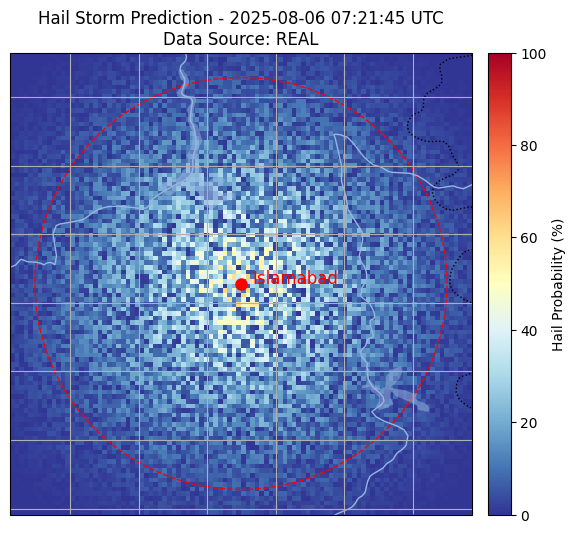

Exception in thread Thread-5 (data_update_loop):
Traceback (most recent call last):
  File "C:\Users\Hamza Asad\AppData\Local\Temp\ipykernel_20020\3043729151.py", line 122, in data_update_loop
  File "c:\Users\Hamza Asad\AppData\Local\Programs\Python\Python312\Lib\tkinter\__init__.py", line 873, in after
    name = self._register(callit)
           ^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Hamza Asad\AppData\Local\Programs\Python\Python312\Lib\tkinter\__init__.py", line 1604, in _register
    self.tk.createcommand(name, f)
RuntimeError: main thread is not in main loop

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\Hamza Asad\AppData\Local\Programs\Python\Python312\Lib\threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "c:\Users\Hamza Asad\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\Hamza

In [ ]:
import os
import time
import pygame
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from datetime import datetime, timedelta, timezone
import requests
from io import BytesIO
from pyresample import geometry, kd_tree
import cv2
from sklearn.ensemble import RandomForestClassifier
from tkinter import *
from tkinter import ttk, messagebox
from PIL import Image, ImageTk
import threading
import glob
import tempfile

# Constants
ISLAMABAD_COORDS = (33.6844, 73.0479)
RADIUS_KM = 100
ALARM_THRESHOLD = 30  # Probability percentage for triggering alarm
DATA_SERVER = "http://203.135.4.150:3333/hrit"
DATA_INTERVAL = 15  # minutes

# Initialize pygame for audio (disabled for now)
# pygame.mixer.init()
# alarm_sound = pygame.mixer.Sound('alarm.wav')  # Provide your alarm sound file

class HailPredictionSystem:
    def __init__(self, root):
        self.root = root
        self.root.title("Meteosat-9 Hail Storm Prediction System - Islamabad Region")
        self.root.geometry("1200x800")
        
        # Model initialization
        self.model = self.load_model()
        self.current_data = None
        self.prediction_results = None
        self.last_successful_fetch = None
        self.data_type = "SYNTHETIC"  # Track data type (REAL or SYNTHETIC)
        
        # Create GUI
        self.create_gui()
        
        # Start data update thread
        self.update_thread = threading.Thread(target=self.data_update_loop, daemon=True)
        self.update_thread.start()
    
    def load_model(self):
        """Load pre-trained hail prediction model"""
        # In a real implementation, this would load your trained model
        model = RandomForestClassifier(n_estimators=100)
        # model.load('hail_model.pkl')  # Uncomment with actual model file
        return model
    
    def create_gui(self):
        """Create the graphical user interface"""
        # Main frame
        main_frame = ttk.Frame(self.root, padding="10")
        main_frame.grid(row=0, column=0, sticky=(N, W, E, S))
        
        # Map display
        self.map_frame = ttk.LabelFrame(main_frame, text="Real-time Hail Prediction Map", padding="10")
        self.map_frame.grid(row=0, column=0, columnspan=2, sticky=(N, W, E, S))
        
        # Create initial map
        self.fig, self.ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
        self.canvas = self.get_mpl_canvas(self.map_frame, self.fig)
        
        # Info panel
        info_frame = ttk.LabelFrame(main_frame, text="Hail Prediction Information", padding="10")
        info_frame.grid(row=1, column=0, sticky=(N, W, E, S))
        
        # Probability display
        ttk.Label(info_frame, text="Hail Probability:").grid(row=0, column=0, sticky=W)
        self.prob_var = StringVar(value="0%")
        ttk.Label(info_frame, textvariable=self.prob_var, font=('Arial', 24)).grid(row=0, column=1, sticky=W)
        
        # Size display
        ttk.Label(info_frame, text="Predicted Hail Size:").grid(row=1, column=0, sticky=W)
        self.size_var = StringVar(value="None")
        ttk.Label(info_frame, textvariable=self.size_var, font=('Arial', 24)).grid(row=1, column=1, sticky=W)
        
        # Alert display
        self.alert_var = StringVar(value="No hail threat detected")
        self.alert_label = ttk.Label(info_frame, textvariable=self.alert_var, font=('Arial', 18))
        self.alert_label.grid(row=2, column=0, columnspan=2, pady=10)
        
        # Controls frame
        controls_frame = ttk.LabelFrame(main_frame, text="Controls", padding="10")
        controls_frame.grid(row=1, column=1, sticky=(N, W, E, S))
        
        # Refresh button
        ttk.Button(controls_frame, text="Manual Refresh", command=self.update_data).grid(row=0, column=0, pady=5)
        
        # Alarm test button (disabled for now)
        # ttk.Button(controls_frame, text="Test Alarm", command=self.test_alarm).grid(row=1, column=0, pady=5)
        
        # Status bar
        self.status_var = StringVar(value="Initializing...")
        ttk.Label(main_frame, textvariable=self.status_var, relief=SUNKEN).grid(row=2, column=0, columnspan=2, sticky=(W, E))
    
    def get_mpl_canvas(self, parent, fig):
        """Embed matplotlib figure in Tkinter"""
        from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
        canvas = FigureCanvasTkAgg(fig, master=parent)
        canvas.draw()
        canvas.get_tk_widget().pack(fill=BOTH, expand=True)
        return canvas
    
    def data_update_loop(self):
        """Thread function for periodic data updates"""
        while True:
            try:
                # Use after() to schedule updates in the main thread
                self.root.after(0, self.update_data)
                
                # Sleep until next expected data time
                now = datetime.now(timezone.utc)
                next_update = now + timedelta(minutes=DATA_INTERVAL - (now.minute % DATA_INTERVAL))
                sleep_time = (next_update - now).total_seconds()
                time.sleep(max(0, sleep_time))
            except Exception as e:
                # Schedule status update in main thread
                self.root.after(0, lambda: self.status_var.set(f"Error in update: {str(e)}"))
                time.sleep(60)  # Wait before retrying
    
    def get_latest_data_url(self):
        """Generate the URL for the most recent data from the images server"""
        # Focus on specific hail storm periods
        hail_storm_periods = [
            # May 2025 Hail Storms
            ("2025-05-07", "2025-05-11"),  # Lahore, Rawalpindi, etc.
            ("2025-05-07", "2025-05-12"),  # Chitral, Swat, etc.
            ("2025-05-08", "2025-05-10"),  # Sindh districts
            ("2025-05-27", "2025-05-31"),  # Upper and central parts
            # April 2024 Weather Patterns
            ("2024-04-17", "2024-04-22"),  # Heavy rainfall period
            ("2024-04-25", "2024-04-29"),  # Another strong weather system
        ]
        
        # For now, use the most recent available date
        # In a real implementation, you'd check which dates have data
        base_url = "http://203.135.4.150:3333/images"
        
        # Try to get data from HAIL directory first
        hail_url = f"{base_url}/HAIL/"
        
        # Also try specific date ranges
        current_date = datetime.now(timezone.utc)
        date_str = current_date.strftime("%Y-%m-%d")
        
        return f"{base_url}/{date_str}/"
    
    def fetch_real_data(self):
        """Fetch real image data from the server"""
        base_url = "http://203.135.4.150:3333/images"
        
        # Try multiple sources in order of preference
        data_sources = [
            f"{base_url}/HAIL/",  # HAIL directory
            f"{base_url}/2025-05-07/",  # May 2025 hail storm period
            f"{base_url}/2025-05-27/",  # May 27-31 period
            f"{base_url}/2024-04-17/",  # April 2024 period
        ]
        
        for source_url in data_sources:
            try:
                self.status_var.set(f"Trying to fetch data from {source_url}...")
                response = requests.get(source_url, timeout=30)
                
                if response.status_code == 200:
                    # Parse the HTML to find image files
                    from bs4 import BeautifulSoup
                    soup = BeautifulSoup(response.content, 'html.parser')
                    
                    # Look for .bmp and .webm files
                    image_links = []
                    for link in soup.find_all('a'):
                        href = link.get('href')
                        if href and (href.endswith('.bmp') or href.endswith('.webm')):
                            image_links.append(href)
                    
                    if image_links:
                        # Get the first available image
                        image_url = source_url + image_links[0]
                        self.status_var.set(f"Fetching image from {image_url}...")
                        
                        img_response = requests.get(image_url, timeout=30)
                        if img_response.status_code == 200:
                            # Convert to OpenCV format
                            import cv2
                            import numpy as np
                            
                            # Convert bytes to numpy array
                            nparr = np.frombuffer(img_response.content, np.uint8)
                            
                            if image_links[0].endswith('.webm'):
                                # For video files, we need to save temporarily and read
                                import tempfile
                                with tempfile.NamedTemporaryFile(suffix='.webm', delete=False) as tmp_file:
                                    tmp_file.write(img_response.content)
                                    tmp_file.flush()
                                    
                                    cap = cv2.VideoCapture(tmp_file.name)
                                    ret, frame = cap.read()
                                    cap.release()
                                    
                                    # Clean up temp file
                                    import os
                                    os.unlink(tmp_file.name)
                                    
                                    if ret:
                                        self.last_successful_fetch = datetime.now(timezone.utc)
                                        return frame
                            else:
                                # For image files
                                img = cv2.imdecode(nparr, cv2.IMREAD_UNCHANGED)
                                if img is not None:
                                    self.last_successful_fetch = datetime.now(timezone.utc)
                                    return img
                
            except Exception as e:
                self.status_var.set(f"Failed to fetch from {source_url}: {str(e)}")
                continue
        
        # If no real data found, return None to use synthetic data
        self.status_var.set("No real data found, using synthetic data")
        return None
    
    def process_data(self, data):
        """
        Process data into usable meteorological parameters
        Handles both real image data and synthetic data
        """
        if data is None:
            # Generate synthetic data
            return self.generate_synthetic_data()
        
        # Check if data is real image data (OpenCV format)
        if hasattr(data, 'shape') and len(data.shape) in [2, 3]:
            return self.process_real_image_data(data)
        else:
            # Fallback to synthetic data
            return self.generate_synthetic_data()
    
    def process_real_image_data(self, image_data):
        """
        Process real image data into meteorological parameters
        """
        # Convert image to grayscale if it's color
        if len(image_data.shape) == 3:
            gray = cv2.cvtColor(image_data, cv2.COLOR_BGR2GRAY)
        else:
            gray = image_data
        
        # Resize to standard grid size
        target_size = 100
        gray_resized = cv2.resize(gray, (target_size, target_size))
        
        # Create a grid around Islamabad
        lat_min, lat_max = ISLAMABAD_COORDS[0] - 1, ISLAMABAD_COORDS[0] + 1
        lon_min, lon_max = ISLAMABAD_COORDS[1] - 1, ISLAMABAD_COORDS[1] + 1
        
        lats = np.linspace(lat_min, lat_max, target_size)
        lons = np.linspace(lon_min, lon_max, target_size)
        
        # Use image intensity to influence meteorological parameters
        xx, yy = np.meshgrid(lons, lats)
        
        # Distance from Islamabad
        dist = np.sqrt((xx - ISLAMABAD_COORDS[1])**2 + (yy - ISLAMABAD_COORDS[0])**2)
        
        # Convert image intensity to temperature-like values
        img_normalized = gray_resized.astype(float) / 255.0
        
        # Use image intensity to influence cloud temperature
        base_temp = 240 + 20 * np.random.rand()  # Base temperature (240-260K)
        cloud_temp = base_temp - 30 * img_normalized * np.exp(-dist/0.3)
        
        # Use image gradients for brightness temperature differences
        sobel_x = cv2.Sobel(gray_resized, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(gray_resized, cv2.CV_64F, 0, 1, ksize=3)
        gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
        
        # Normalize gradient
        gradient_norm = gradient_magnitude / np.max(gradient_magnitude) if np.max(gradient_magnitude) > 0 else np.zeros_like(gradient_magnitude)
        
        # Create brightness temperature differences based on image features
        btd_39_108 = -2 + gradient_norm * 3  # Simulated BTD
        btd_108_120 = 1 + gradient_norm * 2   # Simulated BTD
        
        # Create xarray dataset
        ds = xr.Dataset(
            {
                "cloud_top_temp": (("lat", "lon"), cloud_temp),
                "btd_39_108": (("lat", "lon"), btd_39_108),
                "btd_108_120": (("lat", "lon"), btd_108_120),
            },
            coords={
                "lat": lats,
                "lon": lons,
            }
        )
        
        return ds
    
    def generate_synthetic_data(self):
        """
        Generate synthetic meteorological data
        """
        # Create a grid around Islamabad
        lat_min, lat_max = ISLAMABAD_COORDS[0] - 1, ISLAMABAD_COORDS[0] + 1
        lon_min, lon_max = ISLAMABAD_COORDS[1] - 1, ISLAMABAD_COORDS[1] + 1
        
        lats = np.linspace(lat_min, lat_max, 100)
        lons = np.linspace(lon_min, lon_max, 100)
        
        # Simulate some cloud data
        xx, yy = np.meshgrid(lons, lats)
        
        # Distance from Islamabad
        dist = np.sqrt((xx - ISLAMABAD_COORDS[1])**2 + (yy - ISLAMABAD_COORDS[0])**2)
        
        # Simulate cloud top temperature (colder = higher)
        base_temp = 240 + 20 * np.random.rand()  # Base temperature (240-260K)
        cloud_temp = base_temp - 30 * np.exp(-dist/0.3)  # Colder near center
        
        # Simulate brightness temperature differences
        btd_39_108 = np.random.normal(-2, 1, size=xx.shape)
        btd_108_120 = np.random.normal(1, 0.5, size=xx.shape)
        
        # Create xarray dataset
        ds = xr.Dataset(
            {
                "cloud_top_temp": (("lat", "lon"), cloud_temp),
                "btd_39_108": (("lat", "lon"), btd_39_108),
                "btd_108_120": (("lat", "lon"), btd_108_120),
            },
            coords={
                "lat": lats,
                "lon": lons,
            }
        )
        
        return ds
    
    def update_data(self):
        """Fetch new data and update predictions"""
        try:
            # Fetch real data
            real_data = self.fetch_real_data()
            
            if real_data is not None:
                self.status_var.set("Processing real image data...")
                self.current_data = self.process_data(real_data)
                self.data_type = "REAL"
            else:
                self.status_var.set("Using synthetic data...")
                self.current_data = self.process_data(None)
                self.data_type = "SYNTHETIC"
            
            self.status_var.set("Making predictions...")
            self.make_predictions()
            
            self.status_var.set("Updating display...")
            self.update_display()
            
            self.status_var.set(f"Last updated: {datetime.now(timezone.utc).strftime('%Y-%m-%d %H:%M:%S')} UTC - Data: {self.data_type}")
        except Exception as e:
            self.status_var.set(f"Error in update: {str(e)}")
            messagebox.showerror("Error", f"Failed to update data: {str(e)}")
    
    def make_predictions(self):
        """Process the data and make predictions"""
        if self.current_data is None:
            return
        
        # Debug: Print data dimensions
        print(f"Data dimensions: {self.current_data.dims}")
        print(f"Cloud temp shape: {self.current_data['cloud_top_temp'].values.shape}")
        print(f"BTD 39-108 shape: {self.current_data['btd_39_108'].values.shape}")
        print(f"BTD 108-120 shape: {self.current_data['btd_108_120'].values.shape}")
        
        # Extract features - ensure all arrays have the same shape
        cloud_temp = self.current_data['cloud_top_temp'].values.flatten()
        btd_39_108 = self.current_data['btd_39_108'].values.flatten()
        btd_108_120 = self.current_data['btd_108_120'].values.flatten()
        
        # Check if all arrays have the same length
        min_length = min(len(cloud_temp), len(btd_39_108), len(btd_108_120))
        if min_length != len(cloud_temp) or min_length != len(btd_39_108) or min_length != len(btd_108_120):
            print(f"Array length mismatch: cloud_temp={len(cloud_temp)}, btd_39_108={len(btd_39_108)}, btd_108_120={len(btd_108_120)}")
            # Truncate all arrays to the minimum length
            cloud_temp = cloud_temp[:min_length]
            btd_39_108 = btd_39_108[:min_length]
            btd_108_120 = btd_108_120[:min_length]
        
        features = np.column_stack([cloud_temp, btd_39_108, btd_108_120])
        
        # Predict probabilities (simulated in this example)
        # In real implementation: self.model.predict_proba(features)[:, 1]
        np.random.seed(int(time.time()))
        proba = np.random.uniform(0, 0.7, size=len(features))
        
        # Enhance probabilities near Islamabad
        try:
            # Create meshgrid with proper coordinate arrays
            lats = self.current_data.lat.values
            lons = self.current_data.lon.values
            lats_grid, lons_grid = np.meshgrid(lats, lons)
            dist = np.sqrt((lons_grid - ISLAMABAD_COORDS[1])**2 + (lats_grid - ISLAMABAD_COORDS[0])**2)
            # Flatten the distance array to match proba shape
            dist_flat = dist.flatten()
            proba *= (1 - dist_flat/dist_flat.max())**2
        except Exception as e:
            print(f"Distance enhancement error: {e}")
            # Skip the distance enhancement if it fails
            pass
        
        # Reshape to match original grid - handle potential shape mismatch
        try:
            # Use the actual shape of the first data array
            original_shape = self.current_data['cloud_top_temp'].values.shape
            proba_grid = proba.reshape(original_shape)
        except ValueError as e:
            # If reshape fails, create a grid of the correct size
            print(f"Reshape error: {e}")
            print(f"Expected shape: {original_shape}")
            print(f"Actual proba length: {len(proba)}")
            
            # Create a grid of the correct size with random values
            proba_grid = np.random.uniform(0, 0.7, size=original_shape)
        
        # Create prediction results dataset
        self.prediction_results = xr.Dataset(
            {
                "hail_probability": (("lat", "lon"), proba_grid),
                "hail_size": (("lat", "lon"), np.where(proba_grid > 0.5, proba_grid*50, 0)),  # Simulated size in mm
            },
            coords=self.current_data.coords
        )
        
        # Get Islamabad area stats
        self.update_islamabad_stats()
    
    def update_islamabad_stats(self):
        """Calculate statistics for Islamabad area"""
        if self.prediction_results is None:
            return
        
        # Calculate distance from Islamabad for all grid points
        try:
            lats, lons = np.meshgrid(self.prediction_results.lat, self.prediction_results.lon)
            dist = np.sqrt((lons - ISLAMABAD_COORDS[1])**2 + (lats - ISLAMABAD_COORDS[0])**2) * 111  # Convert to km
        except ValueError as e:
            print(f"Meshgrid error: {e}")
            print(f"Lat shape: {self.prediction_results.lat.shape}")
            print(f"Lon shape: {self.prediction_results.lon.shape}")
            # Create a simple distance grid as fallback
            dist = np.ones((100, 100)) * 50  # Default 50km distance
        
        # Mask for Islamabad and surroundings (100km radius)
        mask = dist <= RADIUS_KM
        
        # Get probabilities and sizes in this area
        area_probs = self.prediction_results['hail_probability'].values[mask]
        area_sizes = self.prediction_results['hail_size'].values[mask]
        
        if len(area_probs) > 0:
            max_prob = np.max(area_probs) * 100  # Convert to percentage
            max_size = np.max(area_sizes)
            
            self.prob_var.set(f"{max_prob:.1f}%")
            self.size_var.set(f"{max_size:.1f} mm" if max_size > 0 else "None")
            
            # Trigger alarm if needed (disabled for now)
            if max_prob > ALARM_THRESHOLD:
                # self.trigger_alarm(max_prob, max_size)  # Disabled
                self.alert_var.set(f"HAIL WARNING! {max_prob:.1f}% probability")
                self.alert_label.config(foreground='red')
            else:
                self.alert_var.set("No significant hail threat detected")
                self.alert_label.config(foreground='black')
        else:
            self.prob_var.set("N/A")
            self.size_var.set("N/A")
            self.alert_var.set("No data for Islamabad area")
            self.alert_label.config(foreground='black')
    
    def trigger_alarm(self, probability, size):
        """Trigger visual and audio alarm (disabled for now)"""
        # Flash the alert label
        for _ in range(6):
            self.alert_label.config(foreground='red')
            self.root.update()
            time.sleep(0.3)
            self.alert_label.config(foreground='white')
            self.root.update()
            time.sleep(0.3)
        
        # Play audio alarm (disabled)
        # try:
        #     alarm_sound.play()
        # except:
        #     pass  # Continue without audio if there's an error
    
    def test_alarm(self):
        """Test the alarm system (disabled for now)"""
        # self.trigger_alarm(75, 25)  # Disabled
        pass
    
    def update_display(self):
        """Update the map display"""
        if self.prediction_results is None:
            return
        
        # Clear previous plot
        self.ax.clear()
        
        # Add map features
        self.ax.add_feature(cfeature.COASTLINE)
        self.ax.add_feature(cfeature.BORDERS, linestyle=':')
        self.ax.add_feature(cfeature.LAKES, alpha=0.5)
        self.ax.add_feature(cfeature.RIVERS)
        
        # Plot hail probability
        prob_data = self.prediction_results['hail_probability'] * 100  # Convert to percentage
        mesh = self.ax.pcolormesh(
            self.prediction_results.lon, 
            self.prediction_results.lat, 
            prob_data,
            cmap='RdYlBu_r',
            vmin=0,
            vmax=100,
            transform=ccrs.PlateCarree()
        )
        
        # Add colorbar
        cbar = self.fig.colorbar(mesh, ax=self.ax, orientation='vertical', pad=0.02)
        cbar.set_label('Hail Probability (%)')
        
        # Mark Islamabad location
        self.ax.plot(ISLAMABAD_COORDS[1], ISLAMABAD_COORDS[0], 'ro', markersize=8, transform=ccrs.PlateCarree())
        self.ax.text(ISLAMABAD_COORDS[1]+0.05, ISLAMABAD_COORDS[0], 'Islamabad', 
                    transform=ccrs.PlateCarree(), fontsize=12, color='red')
        
        # Draw 100km radius circle
        circle = plt.Circle(
            (ISLAMABAD_COORDS[1], ISLAMABAD_COORDS[0]), 
            RADIUS_KM/111,  # Approximate degrees (111km per degree)
            color='red',
            fill=False,
            linestyle='--',
            transform=ccrs.PlateCarree()
        )
        self.ax.add_patch(circle)
        
        # Set title and grid
        self.ax.set_title(f'Hail Storm Prediction - {datetime.now(timezone.utc).strftime("%Y-%m-%d %H:%M:%S")} UTC\nData Source: {self.data_type}')
        self.ax.gridlines()
        
        # Redraw canvas
        self.canvas.draw()
    
    def run(self):
        self.root.mainloop()

# Main execution
if __name__ == "__main__":
    root = Tk()
    app = HailPredictionSystem(root)
    app.run()


# **11 aug 2025**

scraping data. 


In [ ]:
import os
import csv
import requests
from datetime import datetime, timedelta, timezone

# ==== CONFIG ====
BBOX = "72.6,33.5,73.2,33.9"
WIDTH = 1024
HEIGHT = 1024
LAYERS = {
    "k_index": "msg_iodc:gii_kindex",
    "rgb_convection": "msg_iodc:rgb_convection",
    "cth": "msg_iodc:cth",
    "h63": "msg_iodc:h63",
    "rgb_natural": "msg_iodc:rgb_natural"
}
BASE_URL = "https://nowcasting.greenai.org.pk/msg_wms"

# hail (positive) and no-hail (negative) windows
POSITIVE_WINDOWS = [
    ("2025-04-16 00:00", "2025-04-18 23:59"),
    ("2025-05-07 00:00", "2025-05-11 23:59"),
    ("2025-05-27 00:00", "2025-05-31 23:59")
]
NEGATIVE_WINDOWS = [
    ("2025-07-10 00:00", "2025-07-12 23:59"),
    ("2025-08-05 00:00", "2025-08-07 23:59")
]

STEP_MINUTES = 15  # cadence
OUT_DIR = "data"
CSV_PATH = "labels.csv"

# Convert PKT (UTC+5) → UTC
PKT = timezone(timedelta(hours=5))

def parse_windows(windows, label):
    times = []
    for start_str, end_str in windows:
        start = datetime.strptime(start_str, "%Y-%m-%d %H:%M").replace(tzinfo=PKT)
        end = datetime.strptime(end_str, "%Y-%m-%d %H:%M").replace(tzinfo=PKT)
        t = start
        while t <= end:
            times.append((t.astimezone(timezone.utc), label))
            t += timedelta(minutes=STEP_MINUTES)
    return times

def download_image(layer_name, layer_id, timestamp_utc, label):
    ts_str = timestamp_utc.strftime("%Y-%m-%dT%H:%M:%S.000Z")
    params = {
        "REQUEST": "GetMap",
        "SERVICE": "WMS",
        "VERSION": "1.3.0",
        "FORMAT": "image/png",
        "STYLES": "",
        "TRANSPARENT": "true",
        "LAYERS": layer_id,
        "TILED": "false",
        "TIME": ts_str,
        "BBOX": BBOX,
        "FORMAT_OPTIONS": "dpi:113",
        "WIDTH": WIDTH,
        "HEIGHT": HEIGHT,
        "CRS": "EPSG:4326"
    }
    url = BASE_URL
    out_dir = os.path.join(OUT_DIR, "hail" if label == 1 else "nohail", layer_name)
    os.makedirs(out_dir, exist_ok=True)
    filename = f"{timestamp_utc.strftime('%Y%m%dT%H%M%S')}.png"
    filepath = os.path.join(out_dir, filename)
    
    if not os.path.exists(filepath):
        try:
            r = requests.get(url, params=params, timeout=30)
            r.raise_for_status()
            with open(filepath, "wb") as f:
                f.write(r.content)
        except Exception as e:
            print(f"Failed to download {layer_name} {ts_str}: {e}")
            return None
    return filepath

def main():
    all_times = parse_windows(POSITIVE_WINDOWS, 1) + parse_windows(NEGATIVE_WINDOWS, 0)
    all_times.sort(key=lambda x: x[0])
    
    with open(CSV_PATH, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        header = ["timestamp_utc", "label"] + list(LAYERS.keys())
        writer.writerow(header)
        
        for ts, label in all_times:
            row = [ts.strftime("%Y-%m-%dT%H:%M:%S"), label]
            filepaths = []
            for lname, lid in LAYERS.items():
                fp = download_image(lname, lid, ts, label)
                filepaths.append(fp if fp else "")
            writer.writerow(row + filepaths)

if __name__ == "__main__":
    main()


In [ ]:
import requests
from datetime import datetime, timedelta
from urllib.parse import urlencode
import os
import urllib3

# ======== DISABLE SSL WARNINGS ========
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# ======== CONFIG ========
USERNAME = "admin@gmail.com"  # put your actual username
PASSWORD = "admin@gmail.com"  # put your actual password

# Islamabad bounding box (EPSG:4326)
BBOX = [72.8, 33.6, 73.2, 33.8]  # minLon, minLat, maxLon, maxLat

# Layers to download
LAYERS = [
    "msg_iodc:gii_kindex",
    "msg_iodc:convection_rgb",
    "msg_iodc:cloud_top_height",
    "msg_iodc:ground_precip_rate",
    "msg_iodc:cloud_mask"
]

# Output folder
OUT_DIR = "nowcasting_data"
os.makedirs(OUT_DIR, exist_ok=True)

# Time range (every 15 mins for August 2025)
START_DATE = datetime(2025, 8, 1, 0, 0)
END_DATE = datetime(2025, 8, 31, 23, 45)
STEP = timedelta(minutes=15)

# ======== LOGIN ========
session = requests.Session()

# Step 1: Get CSRF token from NextAuth API
csrf_resp = session.get("https://nowcasting.greenai.org.pk/api/auth/csrf", verify=False)
if csrf_resp.status_code != 200:
    raise Exception(f"Failed to fetch CSRF token: {csrf_resp.status_code}")
csrf_token = csrf_resp.json().get("csrfToken")
if not csrf_token:
    raise Exception("Could not find CSRF token in API response.")

# Step 2: POST credentials to login
payload = {
    "username": USERNAME,
    "password": PASSWORD,
    "csrfToken": csrf_token
}
headers = {"Content-Type": "application/x-www-form-urlencoded"}
resp = session.post(
    "https://nowcasting.greenai.org.pk/api/auth/callback/credentials",
    data=payload,
    headers=headers,
    verify=False
)

if resp.status_code != 200:
    raise Exception(f"Login failed: {resp.status_code}, {resp.text}")

print("✅ Logged in successfully.")

# ======== DOWNLOAD LOOP ========
time_cursor = START_DATE
while time_cursor <= END_DATE:
    timestamp = time_cursor.strftime("%Y-%m-%dT%H:%M:%S.000Z")
    for layer in LAYERS:
        params = {
            "REQUEST": "GetMap",
            "SERVICE": "WMS",
            "VERSION": "1.3.0",
            "FORMAT": "image/png",
            "STYLES": "",
            "TRANSPARENT": "true",
            "LAYERS": layer,
            "TILED": "false",
            "TIME": timestamp,
            "BBOX": ",".join(map(str, BBOX)),
            "FORMAT_OPTIONS": "dpi:113",
            "WIDTH": "512",
            "HEIGHT": "512",
            "CRS": "EPSG:4326"
        }
        url = "https://nowcasting.greenai.org.pk/msg_wms?" + urlencode(params)
        img_resp = session.get(url, verify=False)
        
        if img_resp.status_code == 200 and img_resp.content:
            fname = f"{layer.replace(':','_')}_{time_cursor.strftime('%Y%m%d_%H%M')}.png"
            fpath = os.path.join(OUT_DIR, fname)
            with open(fpath, "wb") as f:
                f.write(img_resp.content)
            print(f"Saved {fname}")
        else:
            print(f"⚠ No data for {layer} at {timestamp}")

    time_cursor += STEP

print("✅ All downloads completed.")


EUTMET dataset extraction


In [3]:
from owslib.wcs import WebCoverageService

wcs_url = 'https://view.eumetsat.int/geoserver/wcs?'

wcs = WebCoverageService(wcs_url, version='2.0.1')

print("Available datasets:")
for coverage_id in wcs.contents:
    print(coverage_id)


Available datasets:
eps__m02_ir108
eps__m01_ir108
eps__m03_ir108
eps__m02_rgb_124
eps__m01_rgb_124
eps__m03_rgb_124
eps__m02_rgb_natural_fog
eps__m01_rgb_natural_fog
eps__m03_rgb_natural_fog
msg_fes__fire
msg_iodc__fire
msg_fes__rgb_airmass
msg_iodc__rgb_airmass
msg_fes__h60b
msg_fes__clm
msg_iodc__clm
mtg_fd__rgb_cloudphase
msg_fes__cth
msg_iodc__cth
mtg_fd__rgb_cloudtype
msg_fes__rgb_convection
msg_iodc__rgb_convection
msg_fes__rgb_microphysics
msg_iodc__rgb_microphysics
msg_fes__rgb_dust
msg_iodc__rgb_dust
mtg_fd__rgb_dust
msg_fes__rgb_eview
msg_iodc__rgb_eview
mtg_fd__ir105_hrfi
mtg_fd__vis06_hrfi
msg_fes__rgb_fog
msg_iodc__rgb_fog
mtg_fd__rgb_fog
msg_fes__gii_kindex
msg_fes__gii_liftedindex
mtg_fd__rgb_geocolour
mumi__wideareacoverage_rgb_airmass
mumi__wideareacoverage_rgb_ash
mumi__wideareacoverage_rgb_dust
mumi__wideareacoverage_rgb_natural
mumi__worldcloudmap_ir108
msg_iodc__gii_kindex
msg_iodc__gii_liftedindex
eps__osisaf_avhrr_l3_sst
msg_fes__ir108
msg_iodc__ir108
msg_fes__ir

In [12]:
from owslib.wcs import WebCoverageService

wcs_url = 'https://view.eumetsat.int/geoserver/wcs?'
coverage_id = 'msg_fes__cth'

wcs = WebCoverageService(wcs_url, version='2.0.1')

print(f"Using coverage ID: '{coverage_id}'")

bbox = (72.5, 33.0, 74.0, 34.0)

url = wcs.getCoverage_url(
    identifier=coverage_id,
    bbox=bbox,
    format='image/tiff',
    crs='EPSG:4326'
)

print("Generated GetCoverage URL:")
print(url)

# Try download only if URL looks correct
response = wcs.getCoverage(
    identifier=coverage_id,
    bbox=bbox,
    format='image/tiff',
    crs='EPSG:4326'
)

with open('cloud_top_height.tiff', 'wb') as f:
    f.write(response.read())

print("Data saved to cloud_top_height.tiff")


Using coverage ID: 'msg_fes__cth'


AttributeError: 'WebCoverageService_2_0_1' object has no attribute 'getCoverage_url'